In [560]:
from tensorflow import keras

In [561]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

In [562]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf

In [563]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [564]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)



2024-05-07 17:50:05.864011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]
2024-05-07 17:50:05.864408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4]
	 [[{{node Placeholder/_3}}]]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


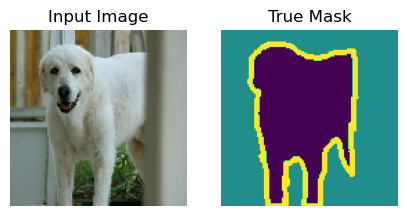

2024-05-07 17:50:07.678061: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


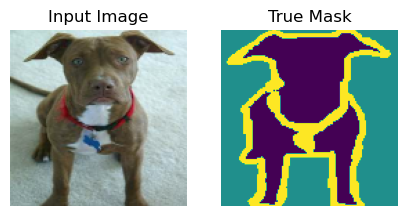

In [565]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

def display(display_list):
  plt.figure(figsize=(5, 5))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
  sample_image = images[0]
  sample_mask = masks[0]
  display([sample_image, sample_mask])

In [566]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [567]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [568]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [569]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

1/1 [==============================] - 1s 641ms/step


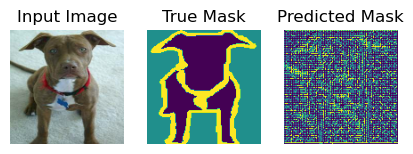

In [570]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
      
show_predictions()

1/1 [==============================] - 0s 35ms/step


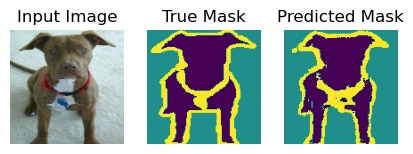


Sample Prediction after epoch 10

57/57 [==============================] - 67s 1s/step - loss: 0.2009 - accuracy: 0.9195 - val_loss: 0.2620 - val_accuracy: 0.9035


In [571]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

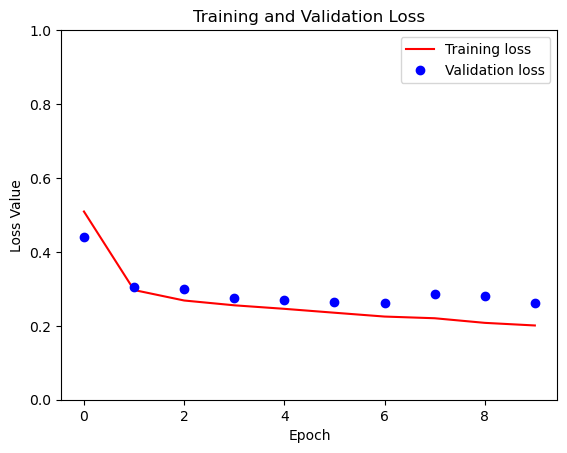

In [572]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2024-05-07 18:01:04.796808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2024-05-07 18:01:04.797217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]


2/2 [==============================] - 1s 306ms/step


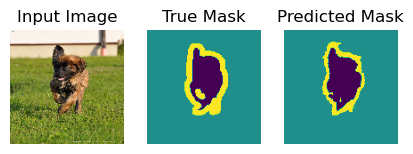

2/2 [==============================] - 1s 270ms/step


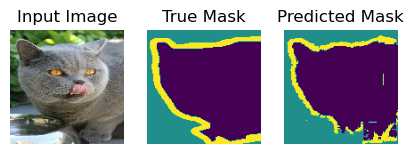

2/2 [==============================] - 1s 255ms/step


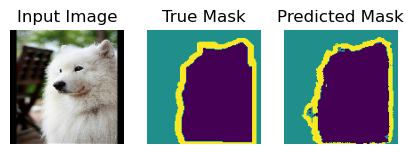

In [573]:
show_predictions(test_batches, 3)

In [574]:
from PIL import Image
import numpy as np
image_path = 'dataset/Train/freshapples/Screen Shot 2018-06-08 at 5.20.08 PM.png'
img = Image.open(image_path)
img = img.convert('RGB')
new_size = (128, 128)
predict_image = img.resize(new_size)
predict_image_before = np.array(predict_image)

predict_image_before = np.expand_dims(predict_image_before, axis=0)

predict_image_before, _ = normalize(predict_image_before, predict_image_before)

pre_prediction = model.predict(predict_image_before)

1/1 [==============================] - 0s 30ms/step


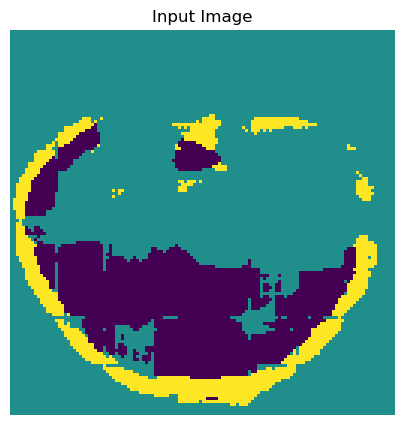

In [575]:
mask_num = create_mask(pre_prediction)

display([mask_num])

In [576]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

images_folder = 'images_for_model'
masks_folder = 'image_masks_for_model'
batch_size = 1
img_size = (128, 128)
num_batches = 53 


def data_generator(images_folder, masks_folder, batch_size, img_size):
    image_paths = sorted(os.listdir(images_folder))
    mask_paths = sorted(os.listdir(masks_folder))
    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same"

    num_batches = len(image_paths) // batch_size
    for i in range(num_batches):
        batch_indices = slice(i * batch_size, (i + 1) * batch_size)
        batch_images = []
        batch_masks = []
        for idx in range(batch_indices.start, batch_indices.stop):
            image_path = os.path.join(images_folder, image_paths[idx])
            mask_path = os.path.join(masks_folder, mask_paths[idx])
            image = (Image.open(image_path))
            mask =(Image.open(mask_path))
            image = image.resize(img_size).convert('RGB')
            mask = mask.resize(img_size).convert('L')
            image_array = np.array(image)
            mask_array = np.array(mask)
            for i in range (128):
                for j in range (128):
                    if mask_array[i][j] == 109: mask_array[i][j] = 2
                    elif mask_array[i][j] == 215: mask_array[i][j] = 3
                    elif mask_array[i][j] == 30: mask_array[i][j] = 1
            mask_array = np.expand_dims(mask_array, axis=-1)
            image_array, mask_array = normalize(image_array, mask_array)
            batch_images.append(image_array)
            batch_masks.append(mask_array)
        batch_images = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        batch_masks = tf.convert_to_tensor(batch_masks, dtype=tf.uint8)
        yield batch_images, batch_masks

In [577]:
# Create the dataset
train_fruit_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(images_folder, masks_folder, batch_size, img_size),
    output_signature=(
        tf.TensorSpec(shape=(None, *img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *img_size, 1), dtype=tf.uint8),
    )
)

In [578]:
model.fit(train_fruit_dataset, epochs=1)

      3/Unknown - 0s 39ms/step - loss: 0.5829 - accuracy: 0.8281 

2024-05-07 18:01:07.722878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


53/53 [==============================] - 3s 48ms/step - loss: 0.2450 - accuracy: 0.9155


1/1 [==============================] - 0s 26ms/step


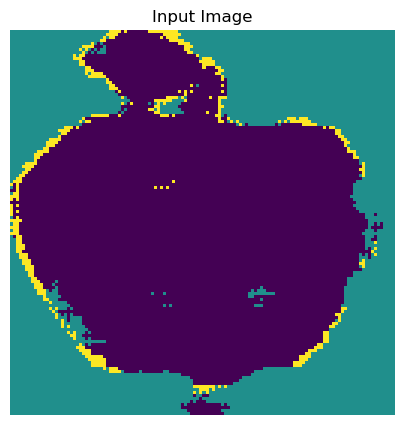

In [579]:
image_path = 'dataset/Train/freshapples/Screen Shot 2018-06-08 at 5.20.08 PM.png'
img = Image.open(image_path)
img = img.convert('RGB')
new_size = (128, 128)
predict_image = img.resize(new_size)
predict_image_after = np.array(predict_image)

predict_image_after = np.expand_dims(predict_image_after, axis=0)

predict_image_after, _ = normalize(predict_image_after, predict_image_after)

post_prediction = model.predict(predict_image_after)

mask_num = create_mask(post_prediction)

display([mask_num])

In [587]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

test_images_folder = 'test_images_for_model'
test_masks_folder = 'test_image_masks_for_model'
test_batch_size = 1
img_size = (128, 128)
num_batches = 9 


def test_data_generator(images_folder, masks_folder, batch_size, img_size):
    image_paths = sorted(os.listdir(images_folder))
    mask_paths = sorted(os.listdir(masks_folder))
    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same"

    num_batches = len(image_paths) // batch_size
    for i in range(num_batches):
        batch_indices = slice(i * batch_size, (i + 1) * batch_size)
        batch_images = []
        batch_masks = []
        for idx in range(batch_indices.start, batch_indices.stop):
            image_path = os.path.join(images_folder, image_paths[idx])
            mask_path = os.path.join(masks_folder, mask_paths[idx])
            image = (Image.open(image_path))
            mask =(Image.open(mask_path))
            image = image.resize(img_size).convert('RGB')
            mask = mask.resize(img_size).convert('L')
            image_array = np.array(image)
            mask_array = np.array(mask)
            for i in range (128):
                for j in range (128):
                    if mask_array[i][j] == 109: mask_array[i][j] = 2
                    elif mask_array[i][j] == 215: mask_array[i][j] = 3
                    elif mask_array[i][j] == 30: mask_array[i][j] = 1
            mask_array = np.expand_dims(mask_array, axis=-1)
            image_array, mask_array = normalize(image_array, mask_array)
            batch_images.append(image_array)
            batch_masks.append(mask_array)
        batch_images = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        batch_masks = tf.convert_to_tensor(batch_masks, dtype=tf.uint8)
        yield batch_images, batch_masks

In [588]:
test_fruit_dataset = tf.data.Dataset.from_generator(
    lambda: test_data_generator(test_images_folder, test_masks_folder, test_batch_size, img_size),
    output_signature=(
        tf.TensorSpec(shape=(None, *img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *img_size, 1), dtype=tf.uint8),
    )
)

In [ ]:
loss, accuracy = model.evaluate(test_fruit_dataset)

In [590]:
print('Loss', loss)
print('Accuracy', accuracy)

Loss 0.383918821811676
Accuracy 0.9217122197151184
